<a href="https://colab.research.google.com/github/TheClub4/Coursera_Capstone/blob/master/Capstone_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strategic Location for Establishing an Asian Restaurant 

## Introduction / Business Problem

The success of establishing a new restaurant depends on several factors: demand, brand loyalty, quality of food, competition, and so on. In most cases, a restaurant's location plays an essential determinant for its success. Hence, it is advantageous and of utmost importance to determine the most strategic location for establishment in order to maximize business profits.

<h3>Business Problem:</h3> Client seeks to establish a franchised Asian restaurant in a Toronto neighborhood. Which neighborhood would appear to be the optimal and most strategic location for the business

A client seeks to establish a franchised Asian restaurant in a Toronto neighborhood. Which neighbourhood would appear to be the optimal and most strategic location for the business operations? 
The objective of this capstone project is to locate the optimal neighborhood for operation. Our foundation of reasoning would be based off of spending power, distribution of ethnic group, and competition, across each neighbourhood. We will mainly be utilizing the Foursquare API and the extensive geographical and census data from Toronto's Open Data Portal. 


## Data
The Foursquare API will be used to explore neighborhoods in Toronto, more specifically, we will be using the <i>explore</i> function to get the most common venue categories in each neighborhood.

Neighbourhood names, alongside their corresponding boroughs and postal codes, scraped from Wikipedia: (https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050)

The Toronto's census data for its social demographic characteristics will be distilled from Toronto's <i>Neighborhood Profile</i> (https://bit.ly/3airrOJ).

Geographical coordinates of each neighbourhood: (https://cocl.us/Geospatial_data)

### Import Data from census CSV files

In [0]:
import pandas as pd
import numpy as np

### Load data and store in respective dataframes

In [2]:
# load total population of each Toronto neighbourhood
pop_path = pd.read_csv('population.csv')
df_pop = pd.DataFrame(pop_path)
df_pop.drop(['Neighbourhood Id'], axis=1, inplace=True)

# load population of Southeast Asians in Toronto neighbourhoods
ethnic_path = pd.read_csv('ethnic.csv')
df_ethnic = pd.DataFrame(ethnic_path)
df_ethnic.drop(['Neighbourhood Id'], axis=1, inplace=True)
df_ethnic.rename(columns={'   Southeast Asian': 'Southeast Asian'}, inplace=True)

# load household income of each Toronto neighbourhood
income_path = pd.read_csv('income.csv')
df_income = pd.DataFrame(income_path)
df_income.drop(['Neighbourhood Id'], axis=1, inplace=True)

print("{}, {}, {}".format(df_ethnic.shape[1], df_pop.shape[1], df_income.shape[1]))

2, 2, 2


### Merge the three dataframes 

In [3]:
from functools import reduce
dfs = [df_pop, df_ethnic, df_income]
df_census = reduce(lambda left,right: pd.merge(left,right,on='Neighbourhood'), dfs)
df_census.rename(columns={'After-Tax Household Income': 'Household Income'}, inplace=True)
df_census

,Neighbourhood,Total Population,Southeast Asian,Household Income
0,West Humber-Clairville,33312.0,490.0,59703.0
1,Mount Olive-Silverstone-Jamestown,32954.0,590.0,46986.0
2,Thistletown-Beaumond Heights,10360.0,120.0,57522.0
3,Rexdale-Kipling,10529.0,170.0,51194.0
4,Elms-Old Rexdale,9456.0,370.0,49425.0
...,...,...,...,...
135,West Hill,27392.0,215.0,46803.0
136,Woburn,53485.0,315.0,47908.0
137,Eglinton East,22776.0,195.0,42790.0
138,Scarborough Village,16724.0,70.0,40181.0


### Merging geographical data

In [4]:
df_geo = pd.read_csv("https://cocl.us/Geospatial_data")
df_geo

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [5]:
df = pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050')[0]

df = df[df.Borough!='Not assigned']
df = pd.merge(df, df_geo, left_on='Postcode', right_on='Postal Code').drop(['Postal Code', 'Postcode', 'Borough'], axis=1)
df = pd.merge(df, df_census, on='Neighbourhood', how='left').dropna(how='any', axis=0).reset_index(drop=True)
df.head()

,Neighbourhood,Latitude,Longitude,Total Population,Southeast Asian,Household Income
0,Victoria Village,43.725882,-79.315572,17510.0,95.0,43743.0
1,Rouge,43.806686,-79.194353,46496.0,295.0,72784.0
2,Malvern,43.806686,-79.194353,43794.0,200.0,53425.0
3,Highland Creek,43.784535,-79.160497,12494.0,85.0,87321.0
4,Flemingdon Park,43.725900,-79.340923,21933.0,230.0,43511.0


### Get the percentage of Southeast Asian in the total population

In [6]:
df['Percentage of Southeast Asian'] = df['Southeast Asian'] / df['Total Population'] * 100
df.drop(['Total Population', 'Southeast Asian'], axis=1, inplace=True)
df.head()

,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Southeast Asian
0,Victoria Village,43.725882,-79.315572,43743.0,0.542547
1,Rouge,43.806686,-79.194353,72784.0,0.634463
2,Malvern,43.806686,-79.194353,53425.0,0.456684
3,Highland Creek,43.784535,-79.160497,87321.0,0.680327
4,Flemingdon Park,43.725900,-79.340923,43511.0,1.048648


### Create a Folium map

In [7]:
# get location of Toronto using geopy
from geopy.geocoders import Nominatim
address = 'Toronto'
geolocator = Nominatim(user_agent='to_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print("The geographical coordinates of Toronto are {}, {}".format(latitude, longitude))

The geographical coordinates of Toronto are 43.653963, -79.387207


In [15]:
# Folium mapping
import folium
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
  label = '{}'.format(neighbourhood)
  label = folium.Popup(label)
  folium.CircleMarker(
      [lat,lng],
      radius=8,
      color='blue',
      popup=label,
      fill_color='#3186cc',
      fill_opacity=0.7,
      fill=True

  ).add_to(map_Toronto)

map_Toronto

### Explore the neighbourhood using the Foursquare API

In [0]:
#@title
# define Foursquare API credentials and version
CLIENT_ID = 'O3UHS1WHTUPGOMNULUPY15042K1BT2WDCAZ3FGUFZ4LEHH43' # your Foursquare ID
CLIENT_SECRET = 'Z4QJCOBA2TAB2TIUM1TB41C2LSN1X4B5B01ISZIUL33O1HQG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Get the top 100 venues that are in Toronto within a radius of 1500 meters

In [0]:
import requests
LIMIT = 100
radius = 1500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT
    )

def getNearbyVenues(names, latitudes, longitudes, radius=1500):
  venues_list = []
  for name, lat, lng in zip(names, latitudes, longitudes):
    print(name)

    #create the API request url
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT
    )

    # make the GET request
    results = requests.get(url).json()['response']['groups'][0]['items']

    # return only relevant information for each nearby venue
    venues_list.append([(
        name,
        lat,
        lng,
        v['venue']['name'],
        v['venue']['location']['lat'],
        v['venue']['location']['lng'],
        v['venue']['categories'][0]['name']) for v in results
        ])
  
  nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
  nearby_venues.columns = ['Neighbourhood',
                           'Neighbourhood Latitude',
                           'Neighbourhood Longitude',
                           'Venue',
                           'Venue Latitude',
                           'Venue Longitude',
                           'Venue Category']

  return(nearby_venues)                         

In [18]:
# run the function above to each neighborhood and create a new dataframe called manhattan_venues
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                 latitudes=df['Latitude'],
                                 longitudes=df['Longitude'])

toronto_venues

Victoria Village
Rouge
Malvern
Highland Creek
Flemingdon Park
Humewood-Cedarvale
Markland Wood
Guildwood
Morningside
West Hill
The Beaches
Woburn
Hillcrest Village
Bathurst Manor
Thorncliffe Park
Scarborough Village
Henry Farm
Little Portugal
Ionview
Kennedy Park
Bayview Village
Oakridge
Humber Summit
Cliffcrest
Mount Dennis
Weston
Dorset Park
Forest Hill North
Willowdale West
Roncesvalles
Agincourt North
Milliken
New Toronto
Alderwood
Long Branch


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
1,Victoria Village,43.725882,-79.315572,Armenian Kitchen,43.731071,-79.305390,Middle Eastern Restaurant
2,Victoria Village,43.725882,-79.315572,Sultan Of Samosas,43.718823,-79.304350,Indian Restaurant
3,Victoria Village,43.725882,-79.315572,Aga Khan Museum,43.725105,-79.332076,History Museum
4,Victoria Village,43.725882,-79.315572,Jatujak,43.736208,-79.307668,Thai Restaurant
...,...,...,...,...,...,...,...
1822,Long Branch,43.602414,-79.543484,Dollarama,43.593866,-79.539825,Discount Store
1823,Long Branch,43.602414,-79.543484,RBC Royal Bank,43.593882,-79.535475,Bank
1824,Long Branch,43.602414,-79.543484,Connorvale Park,43.607201,-79.530702,Park
1825,Long Branch,43.602414,-79.543484,TTC Stop #5511,43.591893,-79.544069,Light Rail Station


Check how many venues were returned for each neighbourhood

In [19]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt North,73,73,73,73,73,73
Alderwood,47,47,47,47,47,47
Bathurst Manor,41,41,41,41,41,41
Bayview Village,15,15,15,15,15,15
Cliffcrest,43,43,43,43,43,43
Dorset Park,56,56,56,56,56,56
Flemingdon Park,86,86,86,86,86,86
Forest Hill North,97,97,97,97,97,97
Guildwood,34,34,34,34,34,34


### Analyze each neighbourhood with One Hot Encoding

In [20]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix='', prefix_sep='')

# add neighbourhood to column back to data frame
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood']

# move neighbourhood column to the first column
cols = list(toronto_onehot)
cols.insert(0, cols.pop(cols.index('Neighbourhood')))
toronto_onehot = toronto_onehot.ix[:,cols]
toronto_onehot

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


,Neighbourhood,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,...,South American Restaurant,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Syrian Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,Long Branch,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1823,Long Branch,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1824,Long Branch,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1825,Long Branch,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Group rows by neighbourhood and by taking the mean of the frequency of occurrence of Asian restaurants

In [0]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped = toronto_grouped[['Neighbourhood', 'Asian Restaurant']]
toronto_grouped.set_index('Neighbourhood', inplace=True)

### Plotting a bar graph to showcase the frequency distribution of Asian restaurants in each neighbourhood.

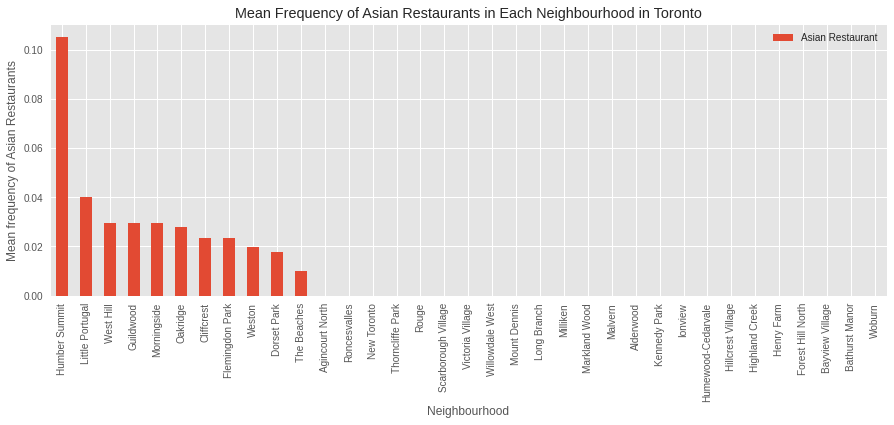

In [22]:
# sort by descending order
toronto_grouped.sort_values(by='Asian Restaurant', ascending=False, inplace=True)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')
toronto_grouped.plot(kind='bar', figsize=(15,5))

plt.title('Mean Frequency of Asian Restaurants in Each Neighbourhood in Toronto')
plt.xlabel('Neighbourhood')
plt.ylabel('Mean frequency of Asian Restaurants')

plt.show()

As inferred from the bar chart, Humber Summit is most densely populated with Asian Restaurants; hence, it is not advisable for business operations to be taken place here.

### Plotting a bar graph to illustrate the distribution of Southeast Asian population group in each neighbourhood

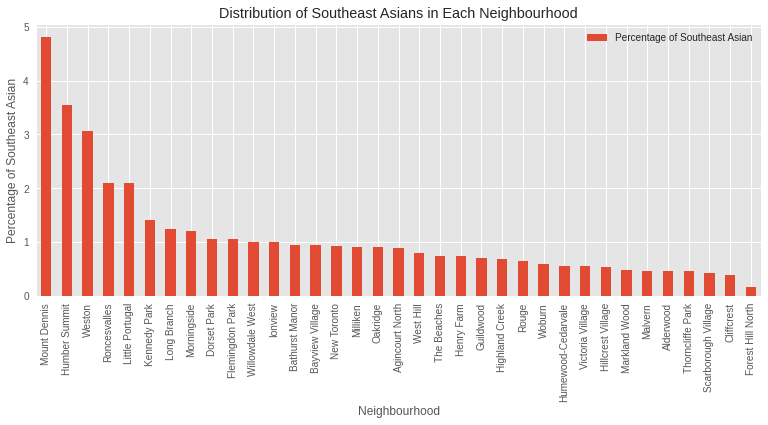

In [23]:
df_ethnic = df[['Neighbourhood', 'Percentage of Southeast Asian']].set_index('Neighbourhood')

# sort by descending order
df_ethnic.sort_values(by='Percentage of Southeast Asian', ascending=False, inplace=True)

#plot bar graph
df_ethnic.plot(kind='bar', figsize=(13,5))
plt.title('Distribution of Southeast Asians in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Percentage of Southeast Asian')

plt.show()

As inferred from above, Mount Dennis is the neighbourhood most densely populated with Southeast Asians.

### Plotting a bar graph to illustrate the distribution of income groups in each neighbourhood

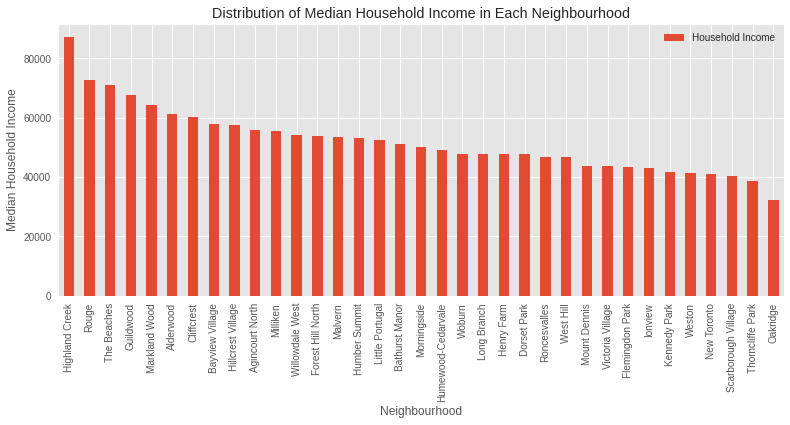

In [24]:
df_income = df[['Neighbourhood', 'Household Income']].set_index('Neighbourhood')

# sort by descending order
df_income.sort_values(by='Household Income', ascending=False, inplace=True)

#plot bar graph
df_income.plot(kind='bar', figsize=(13,5))
plt.title('Distribution of Median Household Income in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Median Household Income')

plt.show()

### Finalise a dataframe for clustering

In [0]:
# merge df with toronto_grouped
df_final = pd.merge(df, toronto_grouped, on='Neighbourhood')

In [28]:
df_final.head()

,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Southeast Asian,Asian Restaurant
0,Victoria Village,43.725882,-79.315572,43743.0,0.542547,0.000000
1,Rouge,43.806686,-79.194353,72784.0,0.634463,0.000000
2,Malvern,43.806686,-79.194353,53425.0,0.456684,0.000000
3,Highland Creek,43.784535,-79.160497,87321.0,0.680327,0.000000
4,Flemingdon Park,43.725900,-79.340923,43511.0,1.048648,0.023256


## Cluster Neighbourhoods

#### Normalizing over the standard deviation
Now let's normalize the dataset. But why do we need normalization in the first place? Normalization is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally. We use __StandardScaler()__ to normalize our dataset.

In [48]:
from sklearn.preprocessing import StandardScaler
X = df_final.values[:,3:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-0.76318401, -0.58195085, -0.50169197],
       [ 1.89181483, -0.48520087, -0.50169197],
       [ 0.12196797, -0.67233002, -0.50169197],
       [ 3.22082273, -0.43692551, -0.50169197],
       [-0.78439402, -0.04923364,  0.64778209],
       [-0.25953784, -0.56683351, -0.50169197],
       [ 1.11591265, -0.65436181, -0.50169197],
       [ 1.4250119 , -0.41005069,  0.95205463],
       [-0.18484571,  0.11333426,  0.95205463],
       [-0.48343137, -0.32685174,  0.95205463],
       [ 1.72478605, -0.37214108, -0.00741812],
       [-0.38240958, -0.53310743, -0.50169197],
       [ 0.51115327, -0.59360511, -0.50169197],
       [-0.09278332, -0.15833173, -0.50169197],
       [-1.22925557, -0.67929527, -0.50169197],
       [-1.08883072, -0.71245837, -0.50169197],
       [-0.40517377, -0.38315284, -0.50169197],
       [ 0.03913925,  1.04564485,  1.47540341],
       [-0.83376213, -0.11132032, -0.50169197],
       [-0.94301194,  0.32230495, -0.50169197],
       [ 0.54278543, -0.1691174 , -0.501

In [87]:
df_normalized = pd.DataFrame(Clus_dataSet)
df_normalized.rename(columns={0:'Household Income', 1:'% Southeast Asian', 2:'No. of Asian Restaurants'}, inplace=True)
df_normalized.head()

,Household Income,% Southeast Asian,No. of Asian Restaurants
0,-0.763184,-0.581951,-0.501692
1,1.891815,-0.485201,-0.501692
2,0.121968,-0.672330,-0.501692
3,3.220823,-0.436926,-0.501692
4,-0.784394,-0.049234,0.647782


### Finding the optimal number of clusters, k
So, how can we choose right value for K? The general solution is to reserve a part of your data for testing the accuracy of the model. Then chose k =1, use the training part for modeling, and calculate the accuracy of prediction using all samples in your test set. Repeat this process, increasing the k, and see which k is the best for your model.



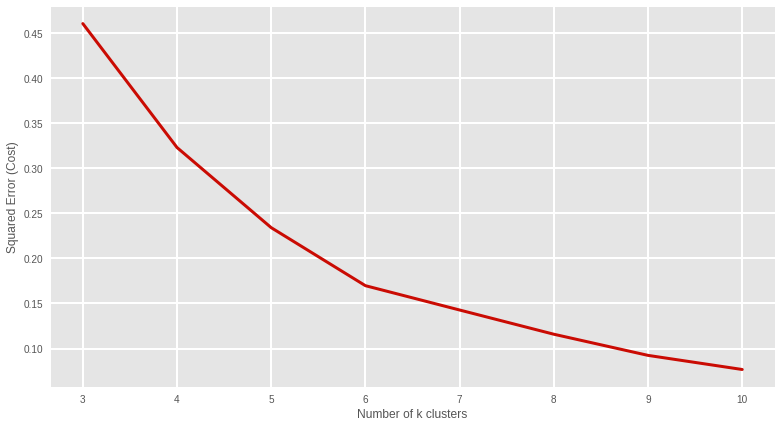

In [88]:
from sklearn.cluster import KMeans

error_cost=[]

for i in range(3, 11):
  KM = KMeans(n_clusters=i, max_iter=100)
  try:
    KM.fit(df_normalized)

  except ValueError:
    print('Error on line', i)

  # calculate squared error for the clustered points
  error_cost.append(KM.inertia_ / 100)

# plot the K values against the squared error cost
plt.figure(figsize=(13,7))
plt.plot(range(3,11), error_cost, color='r', linewidth=3)
plt.xlabel('Number of k clusters')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)

plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f23e67729b0>,
                 k=None, metric=None, model=None, timings=True)

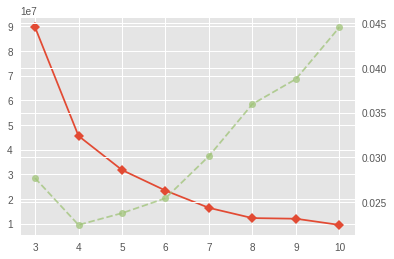

In [55]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,11))

visualizer.fit(X)
visualizer

After analysing using elbow method using distortion score & Squared error for each K value, looks like K = 6 is the best value.

## Clustering the Toronto Neighborhood Using K-Means with K = 6

In [89]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_normalized)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 4, 0, 2, 1, 4, 0, 2, 2], dtype=int32)

Create a new dataframe that includes the cluster

In [0]:
df_normalized.drop(['Household Income', '% Southeast Asian'], axis=1, inplace=True)
df_clustered = pd.merge(df, df_normalized, left_index=True, right_index=True)
df_clustered.insert(0, 'Cluster Label', kmeans.labels_)

### Visulize the clusters on a map

In [91]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude,longitude], zoom_start=11)

# set color schemes for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_clustered['Latitude'], df_clustered['Longitude'], df_clustered['Neighbourhood'], df_clustered['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine clusters

### Cluster 0

In [92]:
df_clustered.loc[df_clustered['Cluster Label'] == 0]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Southeast Asian,No. of Asian Restaurants
1,0,Rouge,43.806686,-79.194353,72784.0,0.634463,-0.501692
3,0,Highland Creek,43.784535,-79.160497,87321.0,0.680327,-0.501692
7,0,Guildwood,43.763573,-79.188711,67678.0,0.705859,0.952055
10,0,The Beaches,43.676357,-79.293031,70957.0,0.741874,-0.007418


### Cluster 1

In [93]:
df_clustered.loc[df_clustered['Cluster Label'] == 1]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Southeast Asian,No. of Asian Restaurants
0,1,Victoria Village,43.725882,-79.315572,43743.0,0.542547,-0.501692
5,1,Humewood-Cedarvale,43.693781,-79.428191,49252.0,0.556909,-0.501692
11,1,Woburn,43.770992,-79.216917,47908.0,0.588950,-0.501692
13,1,Bathurst Manor,43.754328,-79.442259,51076.0,0.945001,-0.501692
14,1,Thorncliffe Park,43.705369,-79.349372,38645.0,0.450066,-0.501692
15,1,Scarborough Village,43.744734,-79.239476,40181.0,0.418560,-0.501692
16,1,Henry Farm,43.778517,-79.346556,47659.0,0.731413,-0.501692
18,1,Ionview,43.727929,-79.262029,42971.0,0.989664,-0.501692
19,1,Kennedy Park,43.727929,-79.262029,41776.0,1.401624,-0.501692
29,1,Roncesvalles,43.648960,-79.456325,46883.0,2.103646,-0.501692


### Cluster 2

In [94]:
df_clustered.loc[df_clustered['Cluster Label'] == 2]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Southeast Asian,No. of Asian Restaurants
4,2,Flemingdon Park,43.725900,-79.340923,43511.0,1.048648,0.647782
8,2,Morningside,43.763573,-79.188711,50069.0,1.203094,0.952055
9,2,West Hill,43.763573,-79.188711,46803.0,0.784901,0.952055
17,2,Little Portugal,43.647927,-79.419750,52519.0,2.088823,1.475403
21,2,Oakridge,43.711112,-79.284577,32079.0,0.902853,0.871291
26,2,Dorset Park,43.757410,-79.273304,47630.0,1.059873,0.380940


### Cluster 3

In [95]:
df_clustered.loc[df_clustered['Cluster Label'] == 3]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Southeast Asian,No. of Asian Restaurants
24,3,Mount Dennis,43.691116,-79.476013,43790.0,4.818657,-0.501692
25,3,Weston,43.706876,-79.518188,41356.0,3.056914,0.467472


### Cluster 4

In [96]:
df_clustered.loc[df_clustered['Cluster Label'] == 4]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Southeast Asian,No. of Asian Restaurants
2,4,Malvern,43.806686,-79.194353,53425.0,0.456684,-0.501692
6,4,Markland Wood,43.643515,-79.577201,64297.0,0.473754,-0.501692
12,4,Hillcrest Village,43.803762,-79.363452,57682.0,0.531475,-0.501692
20,4,Bayview Village,43.786947,-79.385975,58028.0,0.934754,-0.501692
23,4,Cliffcrest,43.716316,-79.239476,60384.0,0.376530,0.647782
27,4,Forest Hill North,43.696948,-79.411307,53978.0,0.156177,-0.501692
28,4,Willowdale West,43.782736,-79.442259,54226.0,1.003779,-0.501692
30,4,Agincourt North,43.815252,-79.284577,55893.0,0.893072,-0.501692
31,4,Milliken,43.815252,-79.284577,55464.0,0.903206,-0.501692
33,4,Alderwood,43.602414,-79.543484,61402.0,0.456280,-0.501692


### Cluster 5

In [97]:
df_clustered.loc[df_clustered['Cluster Label'] == 5]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Southeast Asian,No. of Asian Restaurants
22,5,Humber Summit,43.756303,-79.565963,53272.0,3.543814,4.701191
